## Introduction
- What is the machine learning problem you are trying to solve?
    - We are trying to see if we can build a model that can predict the number of total streams that a popular song has based on the provided features (the number of spotify/deezer playlists it's in, danceability, acousticness, etc)
- Why does the problem matter?
    - Is there a good indicator as to how popular a song gets? Do musical elements matter?
- What could the results of your predictive model be used for?
    - It could be used to analyze trends of popular music/how popular it might get based on other statistics
- Why would we want to be able to predict the thing you're trying to predict?
    - To analyze music trends and how its objective music elements/playlists count factors might impact its popularity
- Describe the dataset.
    - 953 entries where each one is one of the top songs streamed in 2022-2023. Features include the name of the song, the artist(s), the number of spotify playlists it's in, the number of deezer playlists it's in, acousticness, key, danceability, etc.


Using the data collected on songs during one year (2023), we want to predict how many streams a song can accumulate in the span of a year and, in turn, discover its popularity.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("spotify-2023.csv", thousands=',')
raw_data = data.copy()

### 1. Data Prep
#### 1.1 Data Cleaning
Impute missing values 
- Missing keys:

    On review of the songs with missing keys, a majority are C, so all missing keys have been entered as C.
    
    
- Missing in_shazam_charts rankings:

    Imputing a value of 0, as these songs most likely did not land in shazam charts. And modify the datatype to integer like the other in_*_charts features.

In [3]:
print('Raw missing values.')
data.isnull().sum()

Raw missing values.


track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [4]:
print('Check datatypes')
data.info()

Check datatypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    int64  
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    int64  
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      903 non-null    float64
 14  bpm                   953 non-null    int64  
 15  key    

In [5]:
# Fill in NaNs in the key column with C and the NaNs in in_shazam_charts with 0, also turn all objects to ints.
data['key'] = data['key'].fillna("C")
data['in_shazam_charts'] = data['in_shazam_charts'].fillna(0).astype('int')

# Ensure no more NaNs in data
data.isnull().values.any()

False

One-Hot encode categorical values
- Key
 
    Since there are many keys, each gets its own column.
- Mode

    Since there are only two options: major or minor, the column will be transformed into a single column that states whether the song is in minor or not.

In [6]:
# Modify keys
one_hot = pd.get_dummies(data['key'])
data = data.drop('key',axis = 1)
data = data.join(one_hot)

# Modify modes -- binary: Minor vs not-minor
one_hot = pd.get_dummies(data['mode'], drop_first=True)
data = data.drop('mode',axis = 1)
data = data.join(one_hot)

print(data.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...      C     C#      D  \
0                147  141381703          

#### 1.2 Data Exploration

The goal is to find what features may have the largest effect on the number of streams and the popularity of a song. 
One of the easiest ways to see this is through a correlation chart.

In [7]:
# Notable correlations with streams: 
#   in_spotify_playlists, in_apple_playlists, in_apple_charts, in_spotify_charts
data.corrwith(data['streams'], numeric_only=True)

artist_count           -0.135791
released_year          -0.224320
released_month         -0.023571
released_day            0.011907
in_spotify_playlists    0.789730
in_spotify_charts       0.246247
streams                 1.000000
in_apple_playlists      0.772156
in_apple_charts         0.320888
in_deezer_playlists     0.598127
in_deezer_charts        0.228894
in_shazam_charts       -0.006090
bpm                    -0.002015
danceability_%         -0.104462
valence_%              -0.041738
energy_%               -0.026308
acousticness_%         -0.003754
instrumentalness_%     -0.044705
liveness_%             -0.048233
speechiness_%          -0.111577
A                      -0.056823
A#                      0.017307
B                       0.003090
C                       0.004457
C#                      0.060752
D                       0.008566
D#                      0.013183
E                       0.029752
F                      -0.025584
F#                      0.004453
G         

Description & Distribution of the number of streams across songs.

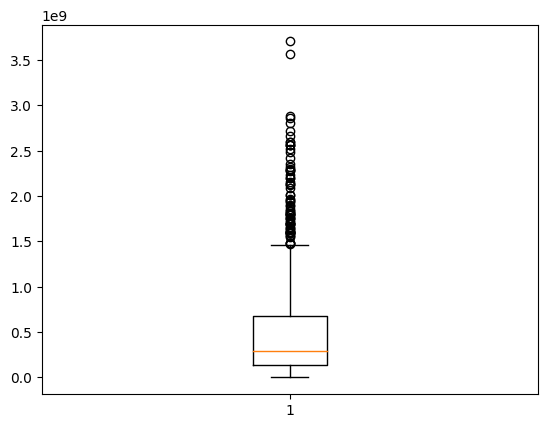

count    9.530000e+02
mean     5.136038e+08
std      5.667986e+08
min      2.762000e+03
25%      1.413817e+08
50%      2.902286e+08
75%      6.738011e+08
max      3.703895e+09
Name: streams, dtype: float64

In [8]:
plt.boxplot(data['streams'])
plt.show()

data['streams'].describe()

**Numerical Distribution** of some of the higher correlation features.

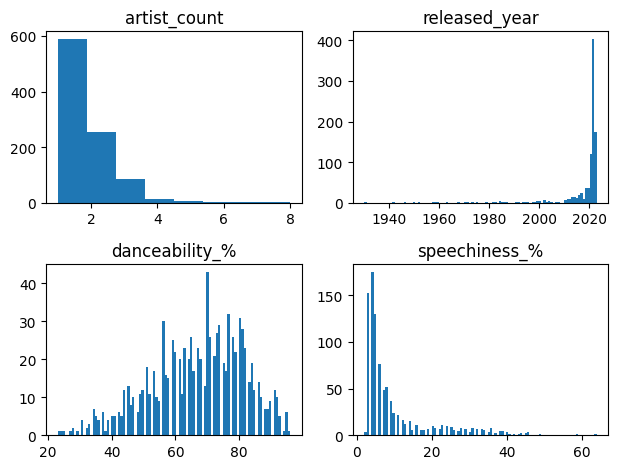

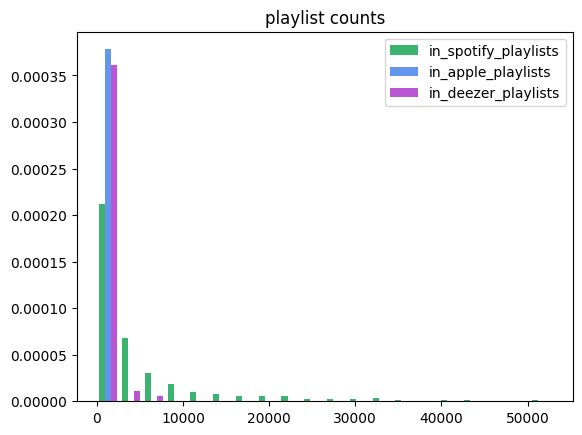

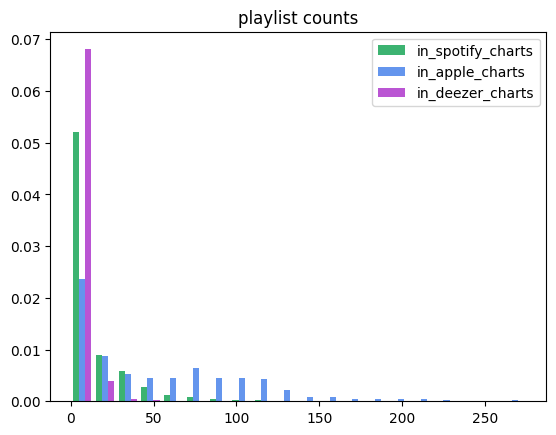

In [9]:
num_dist = ['artist_count', 'released_year', 'danceability_%', 'speechiness_%']


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

ax0.hist(data[num_dist[0]], bins=8)
ax0.set_title(num_dist[0])
ax1.hist(data[num_dist[1]], bins=100)
ax1.set_title(num_dist[1])
ax2.hist(data[num_dist[2]], bins=100)
ax2.set_title(num_dist[2])
ax3.hist(data[num_dist[3]], bins=100)
ax3.set_title(num_dist[3])

fig.tight_layout()
plt.show()


num_dist_playlists = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists', ]

n_bins = 20
x = []
for i in num_dist_playlists:
    x.append(np.array(data[i]))

fig, ax = plt.subplots()
colors = ['mediumseagreen', 'cornflowerblue', 'mediumorchid']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=num_dist_playlists)
ax.legend(prop={'size': 10})
ax.set_title('playlist counts')
plt.show()

num_dist_charts = ['in_spotify_charts', 'in_apple_charts', 'in_deezer_charts']
n_bins = 20
x = []
for i in num_dist_charts:
    x.append(np.array(data[i]))

fig, ax = plt.subplots()
colors = ['mediumseagreen', 'cornflowerblue', 'mediumorchid']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=num_dist_charts)
ax.legend(prop={'size': 10})
ax.set_title('playlist counts')
plt.show()

**Categorial Distributions**

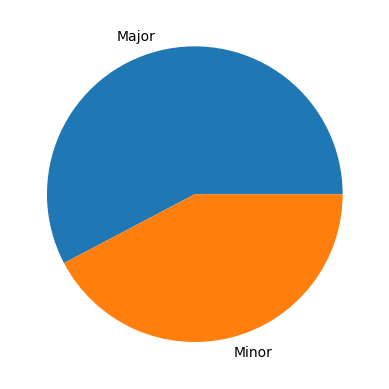

<Axes: ylabel='count'>

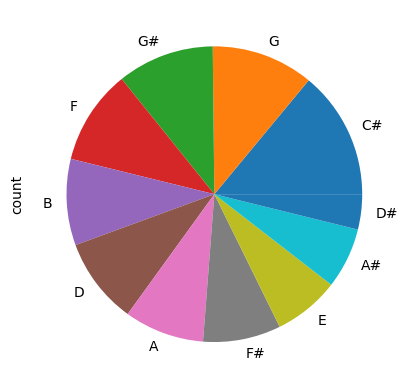

In [10]:

plt.pie(raw_data['mode'].value_counts(), labels=raw_data['mode'].drop_duplicates())
plt.show()

raw_data['key'].value_counts().plot(kind='pie')  

Does the mode of the song have any affect on the number of streams?

What about the song's bpm on chart rankings?

In [11]:
# Mode has a minor effect on the number of streams
print(data.groupby(by=['Minor'])['streams'].mean())

# Some BPMs seem a lot more popular than others.
# notable bpms to appear in charts multiple times (>10):
#   90, 92, 94, 96, 100, 105, 110, 120, 130, 140, 170
pd.options.display.max_rows = 150
data[data['in_spotify_charts'] > 0].groupby(by=['bpm'])['in_spotify_charts'].count()

Minor
False    5.338706e+08
True     4.859445e+08
Name: streams, dtype: float64


bpm
67      1
71      1
72      1
74      1
76      1
77      1
78      3
79      2
80      3
81      3
82      3
83      3
84      3
85      4
87      1
88      4
89      2
90     14
91      2
92     16
93      9
94     11
95     10
96     11
97      4
98     10
99      4
100    11
101     5
102     5
103     4
104     3
105    13
106     1
107     7
108     6
109     3
110    13
111     1
112     4
113     2
114     6
115     6
116     7
117     7
118     6
119     2
120    23
121     5
122    10
123     6
124     9
125    10
126     4
127     2
128    10
129     4
130    25
131     2
132     6
133     5
134     7
135     6
136     6
137     3
138     4
139     5
140    20
141     3
142     5
143     3
144     9
145     6
146     6
147     1
148     4
149     2
150    10
152     1
153     1
154     5
155     2
156     2
157     1
158     3
160     4
161     1
162     1
163     1
164     2
165     1
166     3
168     3
169     2
170    12
171     2
172     5
173     2
174     6
175   

#### 1.3 Feature Engineering
- Remove track & artist names.

    All track names are going to be different. Using artist names would inflate the number of dimensions, which seems to have diminishing returns since most artists are different.

- Remove low correlation features

    Features with low correlation ( |corr| < 0.1 ) are removed to reduce dimensionality and some irrelevant data, such as the number of the day a song was released. 

**Modified dataset after feature engineering**

In [12]:
# Remove low correlation features
data = data.drop(['track_name', 'artist(s)_name', 'released_month', 'released_day',
                 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 
                  'instrumentalness_%', 'liveness_%', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E',
                  'F', 'F#', 'G', 'G#', 'Minor'], axis=1)
data.head()

,artist_count,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,speechiness_%
0,2,2023,553,147,141381703,43,263,45,10,4
1,1,2023,1474,48,133716286,48,126,58,14,4
2,1,2023,1397,113,140003974,94,207,91,14,6
3,1,2019,7858,100,800840817,116,207,125,12,15
4,1,2023,3133,50,303236322,84,133,87,15,6


### 2. Modeling

To build our model, we tried out different supervised learning techniques to see if anything worked well with our dataset. In this section, we explored linear regression, ensembling, knn regressor, and svr, and compared their accuracy.

#### Linear Regression
We first start with a linear regression model since it is simple and computationally efficient. Linear regression acts as a baseline that can give us insights into the complexity of the dataset and guide further modeling choices.

We first tried a simple linear regression between in_spotify_playlists against the number of streams, and the model was not very successful (R2 of 0.48). We then plotted every feature (after feature engineering) against the streams and got a slightly better result (R2 of 0.58)

In [13]:
# simple modeling with streams and in_spotify
spotify = data["in_spotify_playlists"]
streams = data["streams"]
spotify = spotify.values.reshape(-1, 1)
streams = streams.values.reshape(-1, 1)
reg = LinearRegression()

r = cross_val_score(estimator=reg, X=spotify, y=streams, cv=5)
print("Simple regression on in_spotify_playlists vs streams: ")
print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((spotify.shape[0] - 1) / 
          (spotify.shape[0] - spotify.shape[1] - 1))).mean()))

reg = LinearRegression()

x=data.loc[:, data.columns != 'streams']

r = cross_val_score(estimator=reg, X=x, y=streams, cv=5, error_score='raise')
print("\nRegression on the entire dataset: ")

print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((x.shape[0] - 1) / 
          (x.shape[0] - x.shape[1] - 1))).mean()))

Simple regression on in_spotify_playlists vs streams: 
Average R2: 0.48735618013674403
Adjusted R2: 0.48681712249230313

Regression on the entire dataset: 
Average R2: 0.5864382819683992
Adjusted R2: 0.5824912454230287


#### Ensemble: Random Forest Regressor
Since the R2 value of linear regression was pretty low (the regression line does not approximate the actual data well), we proceed to try ensembling with decision tree base classifiers. Decision trees can capture complex relationships between the features and labels, making them well-suited for our dataset where the true relationship may not be linear. When used in ensembling methods like random forests, decision trees can address the issue of high variance associated with individual trees. By aggregating predictions from multiple trees, random forests can provide more stable and generalizable results.

In [14]:
# Define features and labels
features = data.loc[:, data.columns != 'streams']
labels = data["streams"]

# Define ensemble regression model
rfr = RandomForestRegressor()

# Perform Grid Search
param_grid = {
    'n_estimators': [50,100,150]
}
gs = GridSearchCV(rfr, param_grid, cv=5)
gs.fit(features, labels)

# Make predictions using cross-validated model
predictions = cross_val_predict(gs, features, labels, cv=5)

# Evaluate model
r2 = r2_score(labels, predictions)
print("R-squared Score:", r2)

R-squared Score: 0.7907937335506345


#### KNN Models
We decided to try some KNN models since a natural conclusion would be that songs of a similar make-up would end up having similar popularity. 
To achieve results for a normal KNN model, the 'streams' class has been divided into the quartiles found when describing 'streams'.

In [ ]:
# --- KNN Model ---

# Partition class label into four categories of predicted # of streams accumulation
def quarterStreams(e):
    if e <= 141_381_700:
        return 150_000_000
    elif e <= 290_228_600:
        return 300_000_000
    elif e <= 673_801_100:
        return 700_000_000
    else: 
        return 1_000_000_000


# Separate class and features
knn_copy = data.copy()

data_features = knn_copy.drop(columns='streams')
data_class = knn_copy.loc[:, 'streams']
data_class = data_class.apply(quarterStreams)

# Create pipeline
stdsc = sk.preprocessing.StandardScaler()
pca = PCA()
knc = KNeighborsClassifier()
pipeline = Pipeline(steps=(('stdsc', stdsc), ('pca', pca), ('knc', knc)))

# Cross validation
cvs = cross_val_score(pipeline, data_features, data_class, cv=5)
print('Cross validation score: ', cvs.mean())

# Gridsearch 
param_grid = {
    'pca__n_components': list(range(2, 9)),
    'knc__n_neighbors': list(range(1, 25))
}
gscv = GridSearchCV(pipeline, param_grid, cv=5)
gscv_res = gscv.fit(data_features, data_class)
print('\nGRID SEARCH')
print('best params. ', gscv_res.best_params_)
print('best score. ', gscv_res.best_score_)



Cross validation score:  0.48483328740699916


**KNN Regressor**

Since our model is trying to predict a continuous value, KNN Regressor is better suited to handle this by taking the average streams of its surrounding neighbors and uses this value as the prediction.

In [15]:
# Separate fetaures and class columns
feats = data.drop(columns='streams')
labels = data['streams']

# Create pipeline
scaler = sk.preprocessing.StandardScaler()
knr = KNeighborsRegressor()
pipeline = Pipeline(steps=(('scaler', scaler), ('knr', knr)))

# Preform cross validation and get the average score
nested_score = cross_val_score(pipeline, feats, labels, cv=5)
print('Cross Validation Score Average:', nested_score.mean() * 100)

# Preform grid search
param_grid = {
    'knr__n_neighbors': list(range(1, 25))
} 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search = grid_search.fit(feats, labels)
print()
print('Best Parameter:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)


Cross Validation Score Average: 60.446020801957545

Best Parameter: {'knr__n_neighbors': 10}
Best Score: 0.6123952844082059


#### Support Vector Regressor

Due to the data's low performance with linear regression, we decided to test out SVR. By trying out different kernel functions, we are able to transform the data to fit in a more linear feature space. This allows the model to find the best width for the tube that will enclose the data points, as well as, find the best hyperplane that most accurately defines the relationships within the data.

In [16]:

feats = data.drop(columns='streams')
labels = data['streams']

scaler = StandardScaler()
svr = SVR()
pipe = Pipeline([('scaler', scaler), ('svr', svr)])
                
param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.2],
    'svr__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(feats, labels)

svr = SVR(kernel=grid_search.best_params_.get('svr__kernel'), C=grid_search.best_params_.get('svr__C'), 
         epsilon=grid_search.best_params_.get('svr__epsilon'))
svr.fit(feats, labels)

preds = svr.predict(feats)

score = svr.score(feats, labels)
print("R-squared:", score)


R-squared: 0.6939714983699781


### 3. Results

We chose the Random Forest Regressor as our final model. 
- The best parameter found by the grid search is {'n_estimators': 150}. This indicates that the model performed best when using 150 decision trees in the random forest.
- The best score obtained during the grid search is 0.7340. This score represents the decent performance of the model on the validation set with the chosen hyperparameters.
- The R-squared score of 0.7939 indicates that approximately 79.39% of the variance in the target variable (streams) can be explained by the model. This is a relatively high R-squared score, suggesting that our Random Forest Regressor is performing well on the Spotify dataset.
- The Mean Squared Error is a very large number: 6.738741917124921e+16, suggesting that there are substantial differences between predicted and actual values.

Conclusion:
- Answering some of our questions in the beginning, we saw that musical elements did not play a big role in affecting the number of streams. We dropped most of the music features to train our final model (training with these included did not affect the accuracy significantly). However, some of the continuous features affected the model more than the others, as seen by the feature importance graph (attached figure).

In [17]:
from sklearn.metrics import mean_squared_error

# Define features and labels
features = data.loc[:, data.columns != 'streams']
labels = data["streams"]

# Define ensemble regression model
rfr = RandomForestRegressor()

# Perform Grid Search
param_grid = {
    'n_estimators': [50,100,150]
}
gs = GridSearchCV(rfr, param_grid, cv=5)
gs.fit(features, labels)
print('Best Parameter:', gs.best_params_)
print('Best Score:', gs.best_score_)

# Make predictions using cross-validated model
predictions = cross_val_predict(gs, features, labels, cv=5)

# Evaluate model
r2 = r2_score(labels, predictions)
print("R-squared Score:", r2)
mse = mean_squared_error(labels, predictions)
print("Mean Squared Error:", mse)

Best Parameter: {'n_estimators': 50}
Best Score: 0.734772608902637
R-squared Score: 0.7932552806223856
Mean Squared Error: 6.634924448754763e+16


When plotting the actual vs. predicted streams, the points are generally close to the actual=predicted line, showing that our model is doing a decent job at predicting streams. There are some points where the actual streams are significantly larger than the predicted streams. This is likely the cause of the high MSE as the error in some predictions are amplified by their inherently large stream counts. 

The residuals plot supports this reasoning as well since the points become less clustered around the zero residuals line as the number of streams increases. Limited representation of songs with extremely high stream counts in the training data can make it challenging for the model to generalize well to these instances.

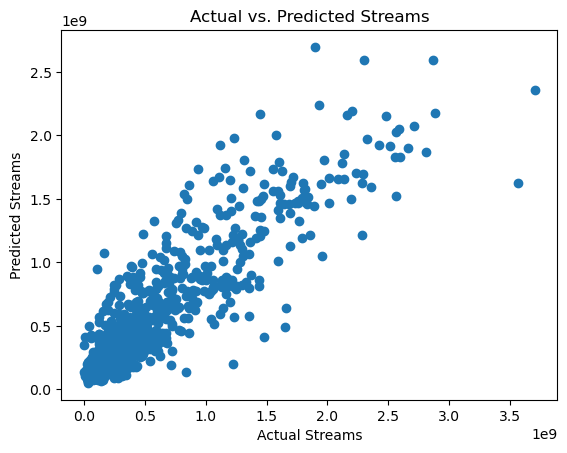

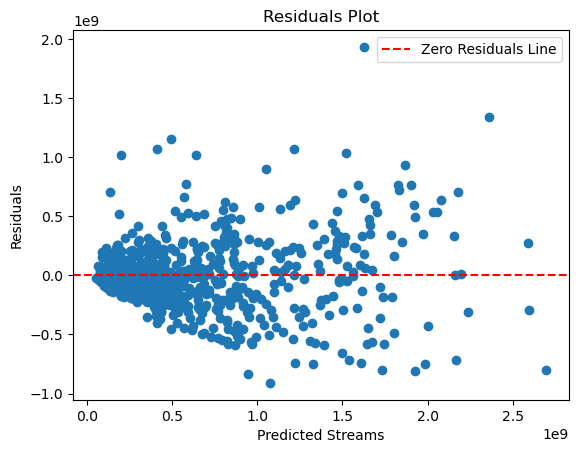

In [18]:
plt.scatter(labels, predictions)
plt.xlabel("Actual Streams")
plt.ylabel("Predicted Streams")
plt.title("Actual vs. Predicted Streams")
plt.show()

residuals = labels - predictions
plt.scatter(predictions, residuals)
plt.xlabel("Predicted Streams")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.title("Residuals Plot")
plt.legend()
plt.show()

**Feature importance in final model**
- Below is a plotted graph of the importance of each feature using feature_importances function that uses impurity as a measure. Notably, speechiness ended up being the only music element that had a correlation > 0.1, and deezer playlist counts led to the most gain for our final model

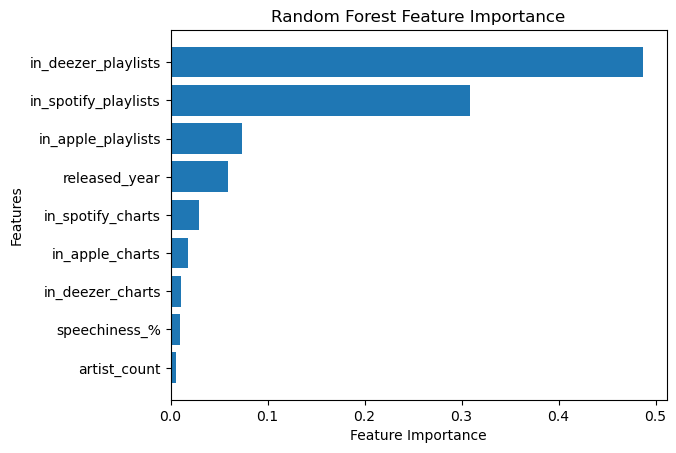

In [19]:
feature_importances = gs.best_estimator_.feature_importances_
feature_names = features.columns
sorted_idx = feature_importances.argsort()

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()